In [59]:
#@title Mounting drive
from google.colab import drive
drive.mount('/content/drive')
# esta constante es importante, depende de donde se tenga guardado este notebook, y es la ruta relativa
CWD = '/content/drive/MyDrive/Proyecto'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
#@title Load libraries
from google.colab.patches import cv2_imshow
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm_notebook, tnrange

from itertools import chain
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images
from sklearn.metrics import precision_score, recall_score

import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import concatenate, add
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator  #img_to_array, array_to_img, load_img

In [61]:
#@title CONSTANTES
NEW_WIDHT = 256
NEW_HEIGHT = 144
ORIGINAL_WIDHT = 1280
ORIGINAL_HEIGHT = 720
WIDTH = 400
HEIGHT = 256
REL_AR = ORIGINAL_WIDHT // NEW_WIDHT

DATASET_PATH = os.path.join(CWD, 'images')
SRC_IMAGES_PATH = os.path.join(DATASET_PATH, 'images')
SRC_MASKS_PATH = os.path.join(DATASET_PATH, 'masks')
IMAGES_PATH = os.path.join(DATASET_PATH, 'resized_images')
MASKS_PATH = os.path.join(DATASET_PATH, 'resized_masks')

In [62]:
#@title **Coding** Create the conv2d block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # First layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [63]:
#@title **Coding** Creating Dice Loss Function
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def call(self, y_true, y_pred):
        intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
        union = tf.reduce_sum(y_true, axis=(1, 2, 3)) + tf.reduce_sum(y_pred, axis=(1, 2, 3))
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1.0 - tf.reduce_mean(dice)
        return dice_loss

In [103]:
#@title Getting X and y
dataset_path = os.path.join(CWD, 'images')
images_path = os.path.join(dataset_path, 'resized_images')
imgs_l = []
masks_l = []
for im in os.listdir(images_path):
  img = cv2.imread(os.path.join(images_path, im))
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  mask = cv2.imread(os.path.join(os.path.join(dataset_path, 'resized_masks'), im))
  gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  imgs_l.append(gray)
  masks_l.append(gray_mask)



X = np.array(imgs_l) / 255.0
y = np.array(masks_l) / 255.0
X = X.reshape(X.shape + (1,))
y = y.reshape(y.shape + (1,))
print("X samples value: ", X.shape, "Y samples value: ", y.shape, "Max value on X: ", np.max(X), "Min value on X", np.min(X))
del imgs_l, masks_l

X samples value:  (125, 256, 400, 1) Y samples value:  (125, 256, 400, 1) Max value on X:  1.0 Min value on X 0.0


In [104]:
#@title Split data and data augmentation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = CWD + '/char/data/'
train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=4)

validation_generator = train_datagen.flow(
        X_valid, y_valid)

In [75]:
#@title **Coding** A nice UNET function
def get_unet(input_img = (HEIGHT, WIDTH, 1), n_filters = 16, dropout = 0.1, batchnorm = True):
  # Contracting Path
  inputs = Input(input_img)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  c1 = conv2d_block(pool1, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)

  print(p1)

  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

def unet(pretrained_weights = None, input_size=(HEIGHT, WIDTH, 1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  # up6 = ZeroPadding2D(padding=((0, 1), (0, 0)))(up6)  # Add 1 column on the right side
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)

  model = Model(inputs, conv10)

  # model.compile(optimizer = Adam(lr = 3e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
  model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  #model.summary()

  if pretrained_weights:
    model.load_weights(pretrained_weights)

  return model

In [ ]:
#@title **Coding** Compiling model
model_1 = unet()
model_1.compile(optimizer=Adam(), loss=DiceLoss(), metrics=["accuracy"])
model_1.summary()

In [51]:
#@title **Coding** Training UNET model
earlystopper = EarlyStopping(patience=6, verbose=1)
checkpointer = ModelCheckpoint(filepath=os.path.join(CWD, 'model_cell_unet.h5'), verbose=1, save_best_only=True)
results_1 = model_1.fit(train_generator,
                    callbacks=[earlystopper, checkpointer],
                    epochs=2,validation_data=validation_generator)


Epoch 1/2
48/48 [==============================] - ETA: 0s - loss: 0.9341 - accuracy: 0.0336 


Epoch 1: val_loss improved from inf to 0.95809, saving model to /content/drive/MyDrive/Proyecto/model_cell_unet.h5
48/48 [==============================] - 820s 17s/step - loss: 0.9341 - accuracy: 0.0336 - val_loss: 0.9581 - val_accuracy: 0.0199
Epoch 2/2
48/48 [==============================] - ETA: 0s - loss: 0.9341 - accuracy: 0.0336 
Epoch 2: val_loss did not improve from 0.95809
48/48 [==============================] - 827s 17s/step - loss: 0.9341 - accuracy: 0.0336 - val_loss: 0.9581 - val_accuracy: 0.0199


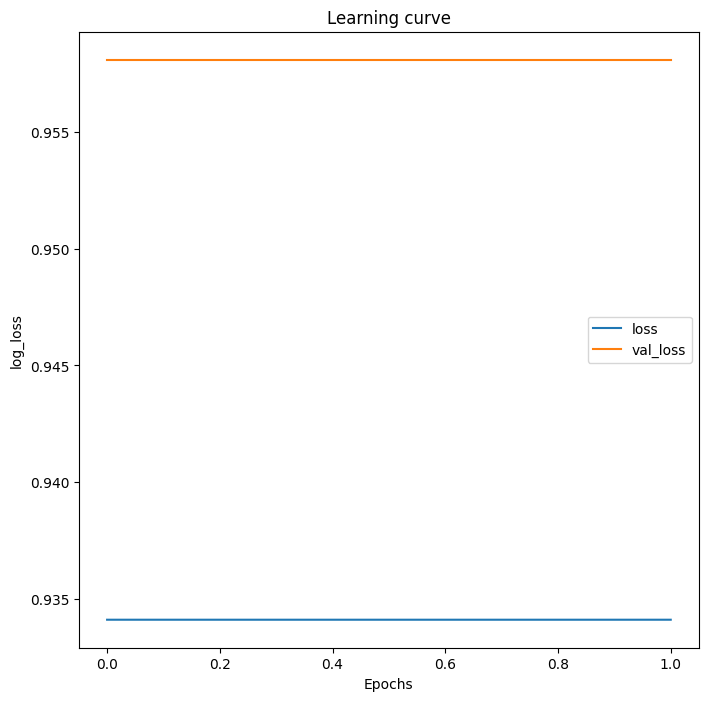

In [81]:
#@title **Coding** To show train and test performance
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results_1.history["loss"], label="loss")
plt.plot(results_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [79]:
#@title **Coding** Defined Autoencoded model
# Autoencoder
def autoencoder(input_size = (HEIGHT, WIDTH, 1)):
    # Encoder
    inputs = Input(input_size)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Embedding
    x = tf.keras.layers.Flatten()(encoded)
    embedding = tf.keras.layers.Dense(400, activation='relu')(x)

    # Decoder
    x = tf.keras.layers.Reshape((16, 25, 1))(embedding)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(inputs, decoded)

    return model

In [ ]:
#@title **Coding** Compiling Autoencoded model
input_img = Input((HEIGHT, WIDTH, 1), name='img')
model_2 = autoencoder()
model_2.compile(optimizer=Adam(), loss=DiceLoss(), metrics=["accuracy"])
model_2.summary()

In [107]:
#@title **Coding** Training Autoencoder model
earlystopper = EarlyStopping(patience=6, verbose=1)
checkpointer = ModelCheckpoint(filepath=os.path.join(CWD, 'model_cell_ae.h5'), verbose=1, save_best_only=True)
results_2 = model_2.fit(train_generator,
                    callbacks=[earlystopper, checkpointer],
                    epochs=8,validation_data=validation_generator)


Epoch 1/8
25/25 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.0398
Epoch 1: val_loss improved from inf to 0.95948, saving model to /content/drive/MyDrive/Proyecto/model_cell_ae.h5
25/25 [==============================] - 52s 2s/step - loss: 0.9424 - accuracy: 0.0398 - val_loss: 0.9595 - val_accuracy: 0.0156
Epoch 2/8
25/25 [==============================] - ETA: 0s - loss: 0.9230 - accuracy: 0.1816
Epoch 2: val_loss improved from 0.95948 to 0.95131, saving model to /content/drive/MyDrive/Proyecto/model_cell_ae.h5
25/25 [==============================] - 47s 2s/step - loss: 0.9230 - accuracy: 0.1816 - val_loss: 0.9513 - val_accuracy: 0.6739
Epoch 3/8
25/25 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.7010
Epoch 3: val_loss improved from 0.95131 to 0.94489, saving model to /content/drive/MyDrive/Proyecto/model_cell_ae.h5
25/25 [==============================] - 46s 2s/step - loss: 0.9158 - accuracy: 0.7010 - val_loss: 0.9449 - val_accu

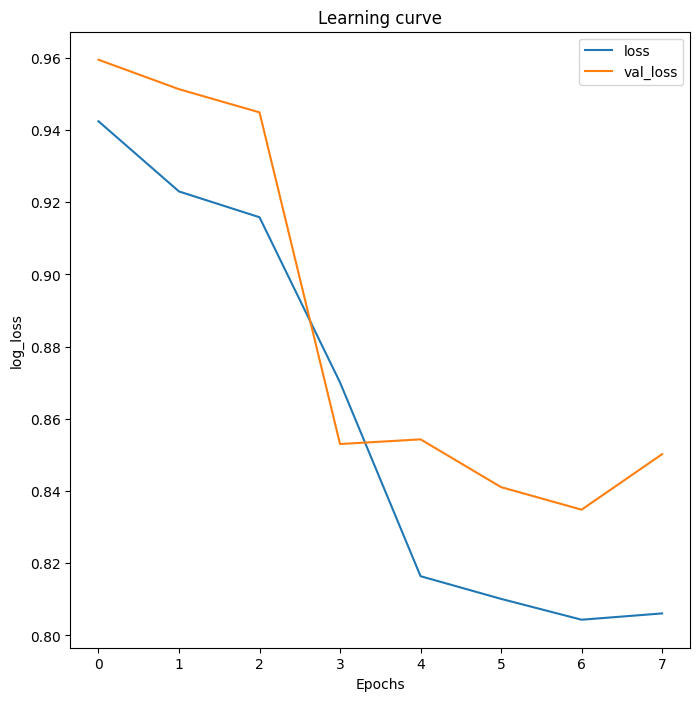

In [108]:
#@title **Coding** To show train and test performance
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results_2.history["loss"], label="loss")
plt.plot(results_2.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
#@title Loading Autoencoder model from h5 file
model_1 = tf.keras.models.load_model(CWD + '/model_cell_unet.h5')

In [147]:
#@title **Coding** post processing
def post_proc(image):
  # Find the most external horizontal and vertical points
  rows, cols = np.nonzero(image)
  leftmost = np.min(cols)
  rightmost = np.max(cols)
  topmost = np.min(rows)
  bottommost = np.max(rows)

  # Create a horizontal rectangle
  post = np.zeros_like(image)
  post[topmost:bottommost+1, leftmost:rightmost+1] = 255
  post = post.reshape(post.shape + (1,))
  return post

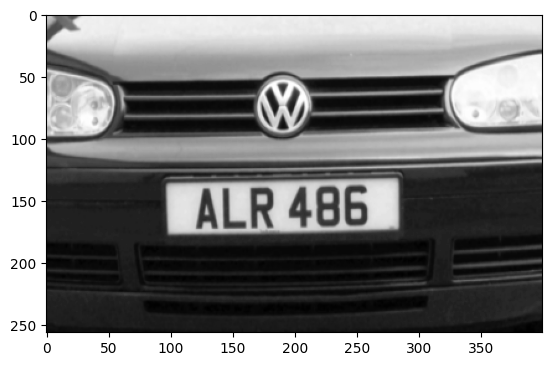

1/1 [==============================] - 0s 147ms/step


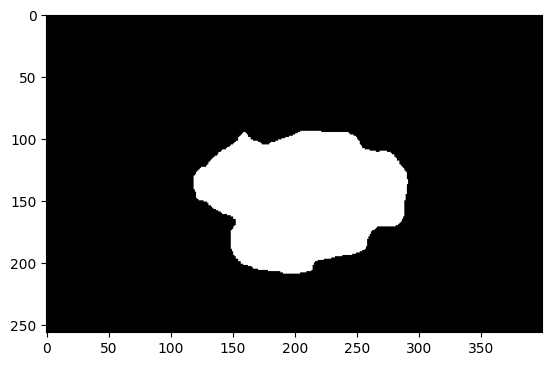

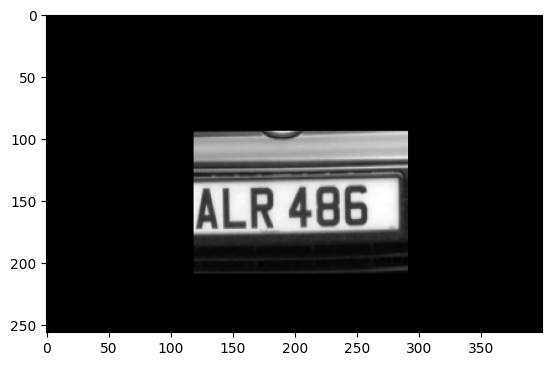

In [150]:
#@title Showing raw prediction
test_idx = 4
img_test = X_valid[test_idx]
plt.imshow(img_test, cmap = 'gray')
plt.show()
pred = model_2.predict(X_train[test_idx].reshape(-1, HEIGHT, WIDTH, 1))
img = (pred > 0.5).astype(np.uint8)
img = img.reshape(img.shape[1:3])
plt.imshow(img, cmap = 'gray')
plt.show()
post = post_proc(img)
plt.imshow(img_test * post, cmap = 'gray')
plt.show()

In [199]:
#@title **Coding** Calculing precision and recall
# Threshold for binarizing the images (to convert them to binary values)
threshold = 0.5  # You may adjust this threshold based on your problem

# Binarize the images
predicted_values = model_2.predict(X_valid)
binary_ground_truth = (y_valid > threshold).astype(np.uint8)
binary_reconstructed = (predicted_values > threshold).astype(np.uint8)

# Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
TP = np.sum(binary_ground_truth * binary_reconstructed)
FP = np.sum((1 - binary_ground_truth) * binary_reconstructed)
FN = np.sum(binary_ground_truth * (1 - binary_reconstructed))

# Calculate Precision and Recall
precision = TP / (TP + FP + np.finfo(float).eps)
recall = TP / (TP + FN + np.finfo(float).eps)

print("Pixel-wise Precision:", precision)
print("Pixel-wise Recall:", recall)

1/1 [==============================] - 2s 2s/step
Pixel-wise Precision: 0.08530353916580764
Pixel-wise Recall: 0.698002403464617


# Character Recognition

In [182]:
#@title **Coding** Preprocessing functions

def crop(image, mask):
  # Verificar si la máscara existe
  if np.sum(mask) == 0:
      print("Image cannot be cropped")
      return None

  # Encontrar los límites de la máscara
  points = np.where(mask != 0)
  x_min = np.min(points[1])
  x_max = np.max(points[1])
  y_min = np.min(points[0])
  y_max = np.max(points[0])

  # Recortar la imagen utilizando los límites de la máscara
  cropped_image = image[y_min:y_max, x_min:x_max]
  return cropped_image

def resize_plate(image):
  return cv2.resize(image, (140, 60))

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

# Find characters in the resulting images
def segment_characters(image) :
    # Preprocess cropped license plate image
    _, img_binary_lp = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [178]:
mask = post / 255
image = X_valid[test_idx]
print("mask shape: ", mask.shape, "Max value on mask: ", np.max(mask), "Min value on mask", np.min(mask))
print("image shape: ", image.shape, "Max value on image: ", np.max(image), "Min value on image", np.min(image))

mask shape:  (256, 400, 1) Max value on mask:  1.0 Min value on mask 0.0
image shape:  (256, 400, 1) Max value on image:  1.0 Min value on image 0.0


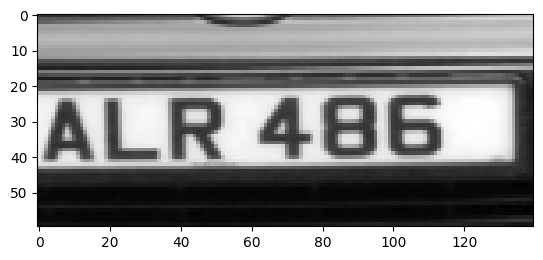

In [170]:
#@title **Coding** Cropping image
crop_image = crop(image, mask)
img = resize_plate(crop_image)
plt.imshow(img, cmap='gray')

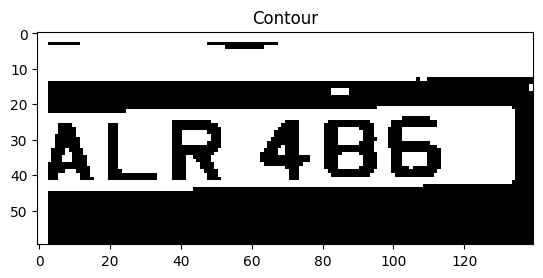

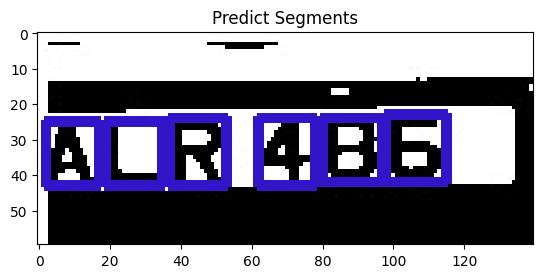

In [183]:
#@title **Coding** Splitting characters
char = segment_characters((img*255).astype("uint8"))

In [186]:
#@title **Coding** Creating new data with data augmentation

train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = CWD + '/char/data/'
train_generator = train_datagen.flow_from_directory(
        path + 'train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path + 'val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
#@title **Coding** Creating new model to character recognition

from numpy.random import seed
seed(1)
model = tf.keras.Sequential()
model.add(Conv2D(16, (3,3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(tf.keras.layers.Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=0.0005), metrics='accuracy')
model.summary()

In [ ]:
#@title **Coding** Training model
batch_size = 1
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint(CWD + '/model_char.h5', verbose=1, save_best_only=True)
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      epochs = 10, verbose=1, callbacks=[earlystopper, checkpointer])

Epoch 1/10
863/864 [============================>.] - ETA: 0s - loss: 2.4191 - accuracy: 0.3604
Epoch 1: val_loss improved from inf to 0.69188, saving model to /content/drive/MyDrive/Proyecto/model_char.h5
864/864 [==============================] - 220s 252ms/step - loss: 2.4175 - accuracy: 0.3611 - val_loss: 0.6919 - val_accuracy: 0.7778
Epoch 2/10
864/864 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.7951
Epoch 2: val_loss improved from 0.69188 to 0.46525, saving model to /content/drive/MyDrive/Proyecto/model_char.h5
864/864 [==============================] - 22s 25ms/step - loss: 0.6748 - accuracy: 0.7951 - val_loss: 0.4652 - val_accuracy: 0.8426
Epoch 3/10
863/864 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8644
Epoch 3: val_loss improved from 0.46525 to 0.24126, saving model to /content/drive/MyDrive/Proyecto/model_char.h5
864/864 [==============================] - 20s 23ms/step - loss: 0.4078 - accuracy: 0.8646 - val_loss: 0.2

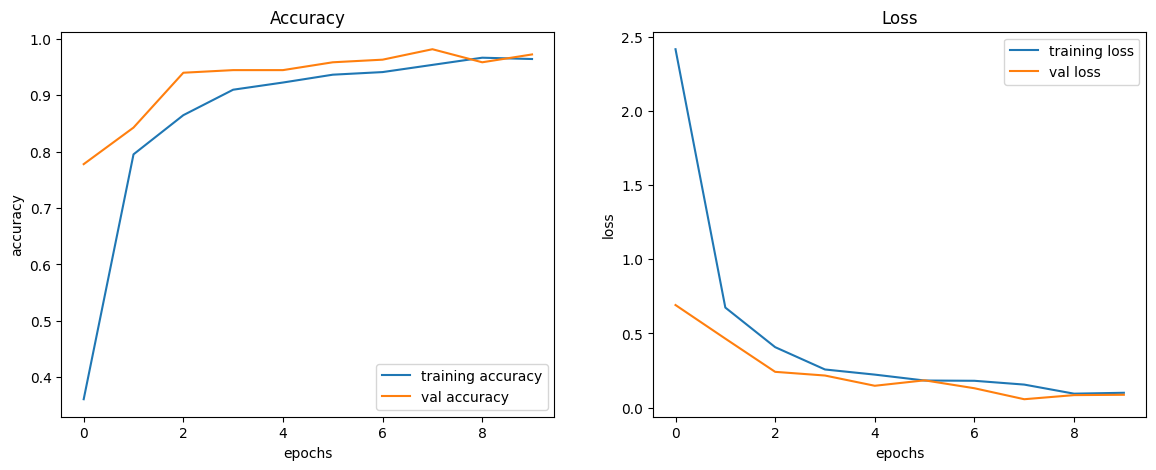

In [ ]:
#@title Plotting accuracy and loss

fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [190]:
#@title **Coding** Load model from h5 file
model = tf.keras.models.load_model(CWD + '/model_char.h5')

In [192]:
#@title **Coding** Post processing functions to predict
# Predicting the output
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        predict_x = model.predict(img, verbose=False)
        y_ = np.argmax(predict_x,axis=1)
        # y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_[0]]
        output.append(character) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number


In [213]:
#@title Calculate precision and recall
predict_x = model.predict(validation_generator)
y_pred = np.argmax(predict_x,axis=1)

# Get true labels from the DirectoryIterator object
y_true = validation_generator.classes

# Calculate precision and recall
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')

print("Precision:", precision)
print("Recall:", recall)

7/7 [==============================] - 3s 263ms/step
Precision: 0.041666666666666664
Recall: 0.041666666666666664


In [193]:
#@title Predicting plate
print(show_results())

ALR4B5


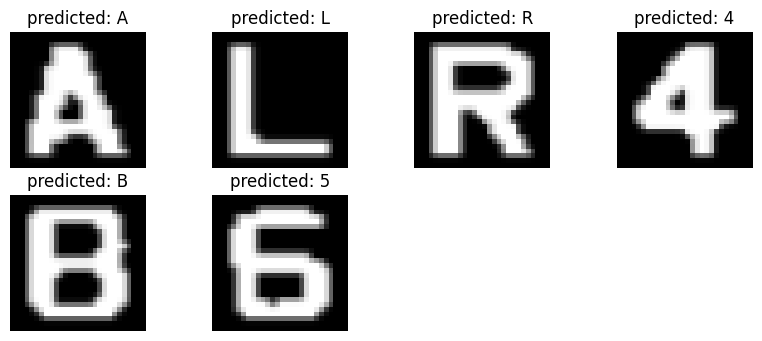

In [196]:
#@title Showing prediction

# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()